# Clustering - Tuto 2

Here we play with a 2D dataset and several clustering methods

The 2D dataset is created from a collection of Argo temperature and salinity profiles interpolated on Standard Depth Levels

Clustering methods are: DBSCAN and KMEANS from scikit-learn

(c) G. Maze

In [1]:
# Libraries import section
import os

import xarray as xr
import numpy as np
# from scipy import stats

from sklearn import preprocessing
# http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

from tuto_tools import *
import intake

# Load data

From Google cloud storage (see specific tuto)

In [2]:
catalog_url = 'https://raw.githubusercontent.com/obidam/m2poc2019/master/m2poc_data_catalog.yml'
ds = intake.Catalog(catalog_url).argo_global_homogeneous_sdl.read_chunked()
print(ds)

<xarray.Dataset>
Dimensions:    (DEPTH: 302, N_PROF: 128910)
Coordinates:
  * DEPTH      (DEPTH) float32 0.0 -5.0 -10.0 -15.0 ... -1495.0 -1500.0 -1505.0
    LATITUDE   (N_PROF) float32 dask.array<shape=(128910,), chunksize=(67010,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(128910,), chunksize=(67010,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(128910,), chunksize=(64455,)>
Dimensions without coordinates: N_PROF
Data variables:
    BRV2       (N_PROF, DEPTH) float32 dask.array<shape=(128910, 302), chunksize=(67010, 302)>
    DBINDEX    (N_PROF) float64 dask.array<shape=(128910,), chunksize=(67010,)>
    PSAL       (N_PROF, DEPTH) float32 dask.array<shape=(128910, 302), chunksize=(67010, 302)>
    SIG0       (N_PROF, DEPTH) float32 dask.array<shape=(128910, 302), chunksize=(67010, 302)>
    TEMP       (N_PROF, DEPTH) float32 dask.array<shape=(128910, 302), chunksize=(67010, 302)>
Attributes:
    Title:             VENTHSAL-IA
    conventions:       CF-1.6
    con

In [3]:
print('This dataset holds: %.3f GB' % (ds.nbytes / 1e9))

This dataset holds: 0.626 GB


# Define a 2D dataset

## Eg 1: Select temperature and salinity from a single depth level

In [4]:
z = -250 # Depth level to select
feat_0 = ds.TEMP.sel(DEPTH=z, method='nearest')
feat_1 = ds.PSAL.sel(DEPTH=z, method='nearest')

## Eg 2: Select temperature from two distinct depth levels

In [5]:
feat_0 = ds.TEMP.sel(DEPTH=0, method='nearest')
feat_1 = ds.TEMP.sel(DEPTH=-1000, method='nearest')

## Create a new xarray DataSet to hold analysis results:

In [6]:
RES = xr.concat([feat_0, feat_1], dim='N_FEATURES').chunk(chunks={'N_PROF':1000})
RES = RES.rename('ARGO')
# Remove obsolete attributes:
for a in RES.attrs.copy(): 
    del RES.attrs[a]
# Add feature names:
RES.attrs['feature_0'] = "%s at %0.2fm depth"%(feat_0.name,feat_0['DEPTH'])
RES.attrs['feature_1'] = "%s at %0.2fm depth"%(feat_1.name,feat_1['DEPTH'])
# We're good:
print(RES)

<xarray.DataArray 'ARGO' (N_FEATURES: 2, N_PROF: 128910)>
dask.array<shape=(2, 128910), dtype=float32, chunksize=(1, 1000)>
Coordinates:
    LATITUDE   (N_PROF) float32 dask.array<shape=(128910,), chunksize=(1000,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(128910,), chunksize=(1000,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(128910,), chunksize=(1000,)>
    DEPTH      (N_FEATURES) float32 dask.array<shape=(2,), chunksize=(2,)>
Dimensions without coordinates: N_FEATURES, N_PROF
Attributes:
    feature_0:  TEMP at 0.00m depth
    feature_1:  TEMP at -1000.00m depth


### Possibly sub-sample the array for faster computation

In [7]:
n = 10000 # Nb of sample to keep
# print(len(RES.N_PROF))
ii = np.random.choice(range(len(RES.N_PROF)), n, replace=False)
RES = RES.isel(N_PROF=ii).chunk({'N_PROF':n/10})
print(RES)

/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/xarray/core/indexing.py:1201: PerformanceWarning: Slicing with an out-of-order index is generating 77 times more chunks
  return self.array[key]


<xarray.DataArray 'ARGO' (N_FEATURES: 2, N_PROF: 10000)>
dask.array<shape=(2, 10000), dtype=float32, chunksize=(1, 1000)>
Coordinates:
    LATITUDE   (N_PROF) float32 dask.array<shape=(10000,), chunksize=(1000,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(10000,), chunksize=(1000,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(10000,), chunksize=(1000,)>
    DEPTH      (N_FEATURES) float32 dask.array<shape=(2,), chunksize=(2,)>
Dimensions without coordinates: N_FEATURES, N_PROF
Attributes:
    feature_0:  TEMP at 0.00m depth
    feature_1:  TEMP at -1000.00m depth


# Dataset PDF

## Marginal PDFs

/home8/homedir3/perso/gmaze/miniconda3/envs/obidam36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


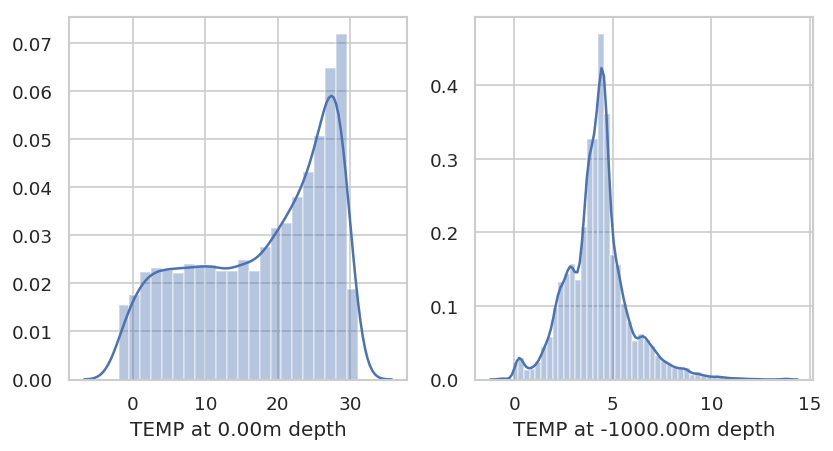

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(0.5), dpi=120, facecolor='w', edgecolor='k')
sns.distplot(RES.isel(N_FEATURES=0), norm_hist=True, axlabel=RES.attrs['feature_0'], ax=ax[0])
sns.distplot(RES.isel(N_FEATURES=1), norm_hist=True, axlabel=RES.attrs['feature_1'], ax=ax[1])

## Marginal and 2D PDFs:

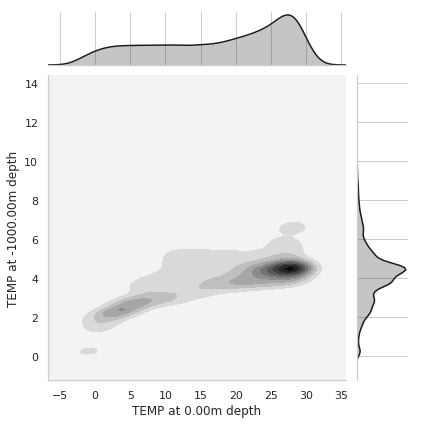

In [9]:
g = (sns.jointplot(x=RES.isel(N_FEATURES=0), y=RES.isel(N_FEATURES=1), kind="kde", color="k")
     .set_axis_labels(RES.attrs['feature_0'], RES.attrs['feature_1'])
     .plot_joint(sns.kdeplot, zorder=0, n_levels=6))

## Exercice

Plot conditional PDFs: p(x1|x2)

# Clustering in 2D

Clearly from the figure above, one can see that the dataset exhibits several modes. 
In other words, data samples agregated into several clusters.

Let's identify them

## Prepare data (normalisation)

In [10]:
# Scaler
X = RES.values.T # Ensure we have sampling x features
print(X.shape)

# Fit the scaler object:
scaler = preprocessing.StandardScaler()
%time scaler = scaler.fit(X)

# The mean and std profiles are in the scaler object properties:
X_ave = scaler.mean_
X_std = scaler.scale_
print("Data mean and std:", X_ave, X_std)

# Normalize data:
Xn = scaler.transform(X) 
# print(Xn.shape)

# Add results to the dataset:
RES['TEMPnorm'] = xr.DataArray(Xn[:,0], dims='N_PROF')
RES['PSALnorm'] = xr.DataArray(Xn[:,1], dims='N_PROF')

(10000, 2)
CPU times: user 1 ms, sys: 0 ns, total: 1 ms
Wall time: 1.36 ms
Data mean and std: [17.66050156  4.23137578] [9.39475904 1.6096329 ]


## Clustering with DBSCAN

In [18]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.1, min_samples=50).fit(Xn)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

# Add results to the dataset:
RES['DBSCAN'] = xr.DataArray(labels, dims='N_PROF')

print(RES)

Estimated number of clusters: 4
<xarray.DataArray 'ARGO' (N_FEATURES: 2, N_PROF: 10000)>
dask.array<shape=(2, 10000), dtype=float32, chunksize=(1, 1000)>
Coordinates:
    LATITUDE   (N_PROF) float32 dask.array<shape=(10000,), chunksize=(1000,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(10000,), chunksize=(1000,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(10000,), chunksize=(1000,)>
    DEPTH      (N_FEATURES) float32 dask.array<shape=(2,), chunksize=(2,)>
    TEMPnorm   (N_PROF) float32 -1.365611 -1.2054027 ... 1.0203271 0.6322116
    PSALnorm   (N_PROF) float32 -1.0908151 -0.97349733 ... -0.09522838
    DBSCAN     (N_PROF) int64 0 0 0 1 -1 1 2 1 -1 1 -1 ... 1 -1 1 0 1 1 -1 0 1 1
    KMEANS     (N_PROF) int32 1 1 1 2 1 2 0 2 3 2 2 3 ... 2 2 2 2 1 2 2 5 1 2 2
Dimensions without coordinates: N_FEATURES, N_PROF
Attributes:
    feature_0:  TEMP at 0.00m depth
    feature_1:  TEMP at -1000.00m depth


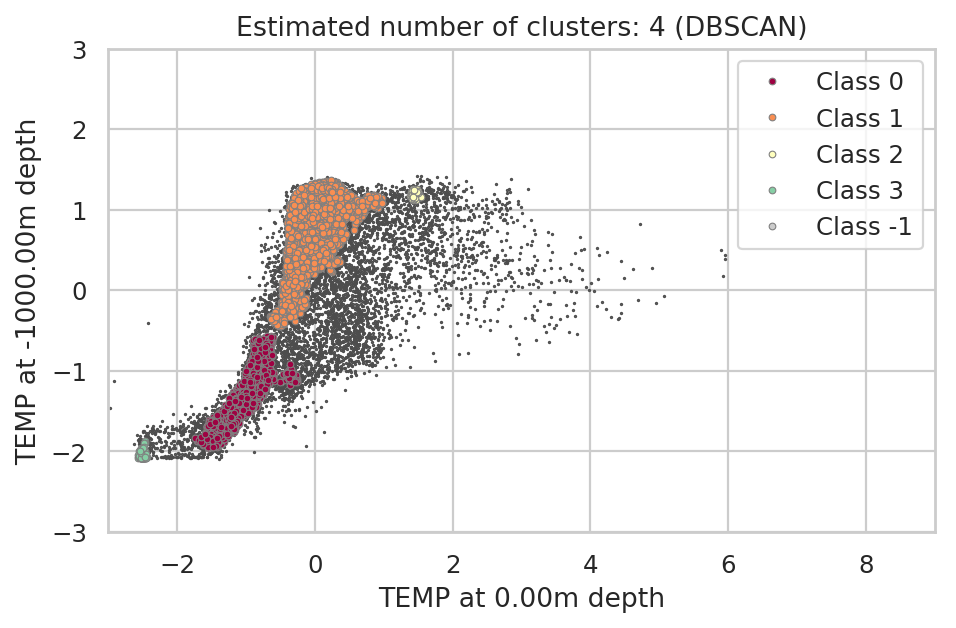

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.6), dpi=90, facecolor='w', edgecolor='k')

# 
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.plot(Xn[:,1],Xn[:,0],'k.',markersize=1,color=[0.3]*3)

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0.2]
#     print "Cluster: ", k, col
    
    class_member_mask = (labels == k)

    xy = Xn[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
             markeredgecolor=[0.5]*3, markersize=3, markeredgewidth=0.5, label="Class %i"%(k))

#     xy = Xn[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='none', markersize=3, label="Noise class %i"%(k))

plt.xlim(-3,9)
plt.ylim(-3,3)
plt.xlabel(RES.attrs['feature_0'])
plt.ylabel(RES.attrs['feature_1'])
plt.title('Estimated number of clusters: %d (DBSCAN)' % n_clusters_)
plt.legend()
plt.show()

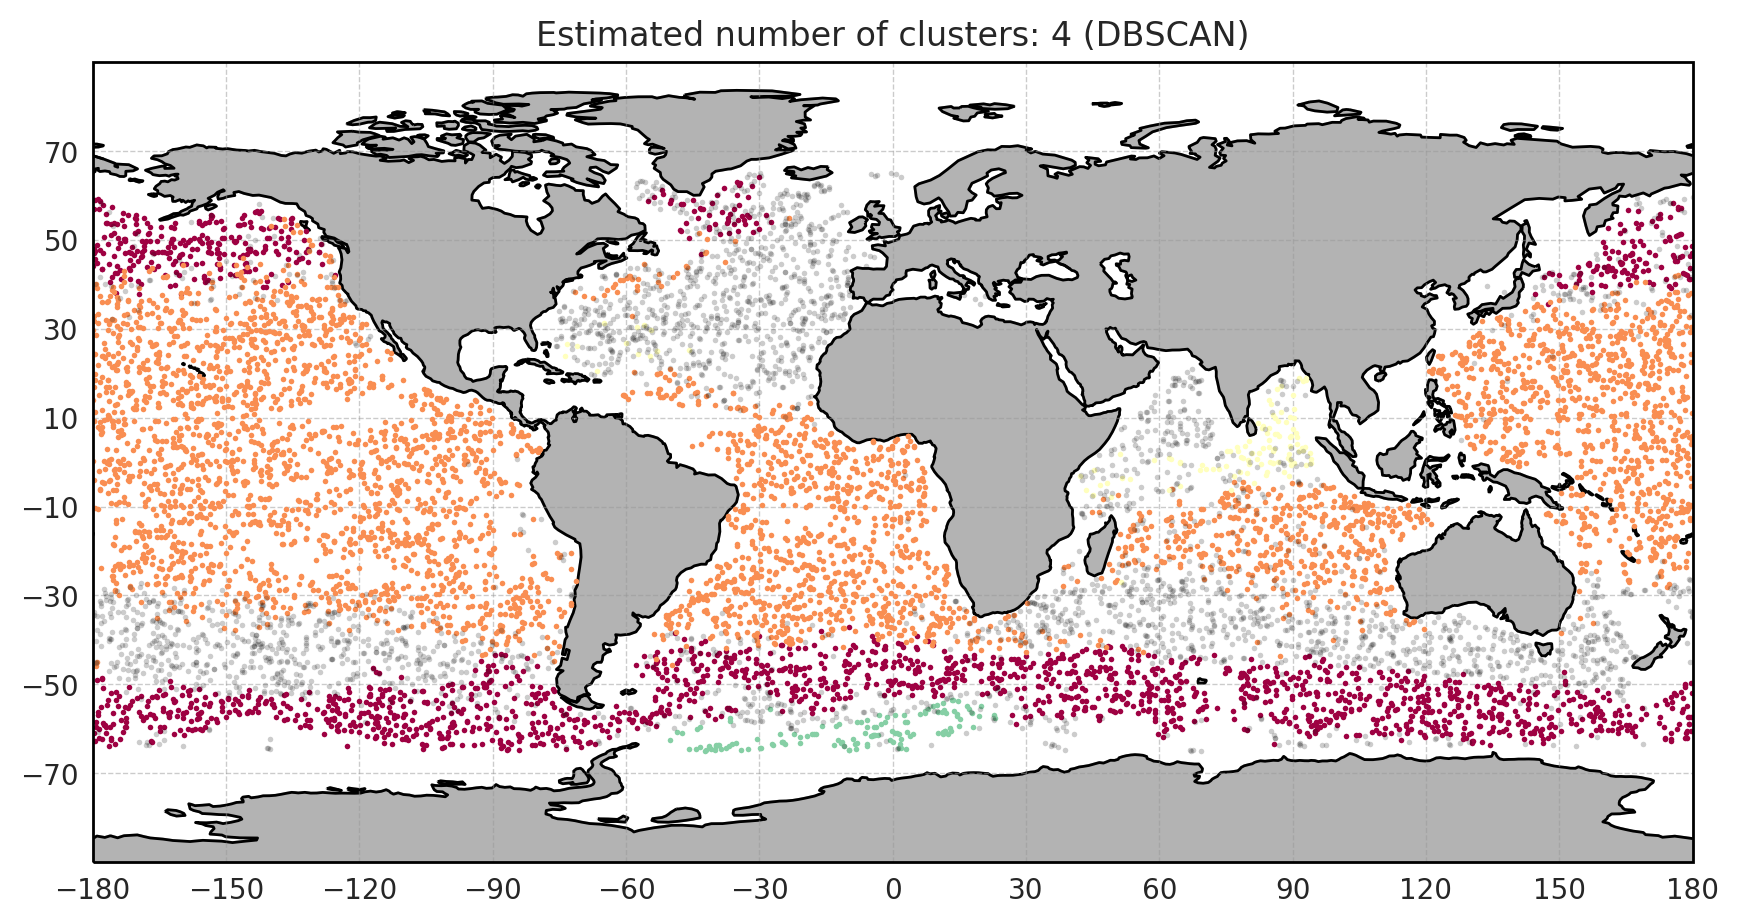

In [13]:
fig, proj, ax = create_map(extent=[-180, 180, -90, 90])

# plt.scatter(RES.LONGITUDE,RES.LATITUDE,5,RES.DBSCAN,transform=proj)

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0.2]
#     print "Cluster: ", k, col
    
    class_member_mask = (RES.DBSCAN == k)

    plt.plot(RES.LONGITUDE[class_member_mask],
                RES.LATITUDE[class_member_mask],
                 'o', markerfacecolor=tuple(col),
                 markeredgecolor='none', markersize=2,  
             label="Class %i"%(k), transform=proj)

plt.title('Estimated number of clusters: %d (DBSCAN)' % n_clusters_)
# plt.legend()
plt.show()

In [19]:
# Clustering with KMeans
from sklearn.cluster import KMeans

%time kmeans = KMeans(n_clusters=6, random_state=0).fit(Xn)
labels = kmeans.predict(Xn)
n_clusters_ = kmeans.n_clusters
kmeans.cluster_centers_.shape

# Add results to the dataset:
RES['KMEANS'] = xr.DataArray(labels, dims='N_PROF')

print(RES)

CPU times: user 1.88 s, sys: 0 ns, total: 1.88 s
Wall time: 317 ms
<xarray.DataArray 'ARGO' (N_FEATURES: 2, N_PROF: 10000)>
dask.array<shape=(2, 10000), dtype=float32, chunksize=(1, 1000)>
Coordinates:
    LATITUDE   (N_PROF) float32 dask.array<shape=(10000,), chunksize=(1000,)>
    LONGITUDE  (N_PROF) float32 dask.array<shape=(10000,), chunksize=(1000,)>
    TIME       (N_PROF) datetime64[ns] dask.array<shape=(10000,), chunksize=(1000,)>
    DEPTH      (N_FEATURES) float32 dask.array<shape=(2,), chunksize=(2,)>
    TEMPnorm   (N_PROF) float32 -1.365611 -1.2054027 ... 1.0203271 0.6322116
    PSALnorm   (N_PROF) float32 -1.0908151 -0.97349733 ... -0.09522838
    DBSCAN     (N_PROF) int64 0 0 0 1 -1 1 2 1 -1 1 -1 ... 1 -1 1 0 1 1 -1 0 1 1
    KMEANS     (N_PROF) int32 1 1 1 2 1 2 0 2 3 2 2 3 ... 2 2 2 2 1 2 2 5 1 2 2
Dimensions without coordinates: N_FEATURES, N_PROF
Attributes:
    feature_0:  TEMP at 0.00m depth
    feature_1:  TEMP at -1000.00m depth


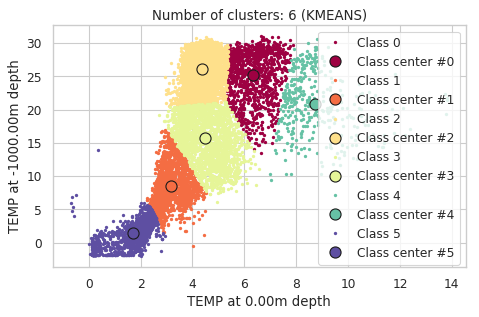

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=plt.figaspect(0.6), dpi=80, facecolor='w', edgecolor='k')

unique_labels = np.unique(RES['KMEANS'])
n_clusters_ = unique_labels.shape[0]
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(range(n_clusters_), colors):
#     print "Cluster: ", k, col
    class_members = RES['KMEANS'] == k
#     plt.plot(RES['PSALnorm'][class_members], RES['TEMPnorm'][class_members], '.', 
#              markerfacecolor=tuple(col), markeredgecolor='none')

#     cluster_center = kmeans.cluster_centers_[k,:]
#     plt.plot(cluster_center[1], cluster_center[0], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=14, label='Class %i'%(k))
    
    plt.plot(RES.sel(N_FEATURES=1)[class_members], RES.sel(N_FEATURES=0)[class_members], '.', 
             markerfacecolor=tuple(col), markeredgecolor='none', label='Class %i'%(k))

    cluster_center = scaler.inverse_transform(kmeans.cluster_centers_[k,:])
    plt.plot(cluster_center[1], cluster_center[0], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10, label='Class center #%i'%(k))

# plt.xlim(-3,9)
# plt.ylim(-3,3)
plt.xlabel(RES.attrs['feature_0'])
plt.ylabel(RES.attrs['feature_1'])
plt.title('Number of clusters: %i (KMEANS)' % n_clusters_)
plt.legend()
plt.show()

Cluster:  0 (0.6196078431372549, 0.00392156862745098, 0.25882352941176473, 1.0)
Cluster:  1 (0.9568627450980393, 0.42745098039215684, 0.2627450980392157, 1.0)
Cluster:  2 (0.996078431372549, 0.8784313725490196, 0.5450980392156862, 1.0)
Cluster:  3 (0.9019607843137256, 0.9607843137254902, 0.5960784313725491, 1.0)
Cluster:  4 (0.4, 0.7607843137254902, 0.6470588235294118, 1.0)
Cluster:  5 (0.3686274509803922, 0.30980392156862746, 0.6352941176470588, 1.0)


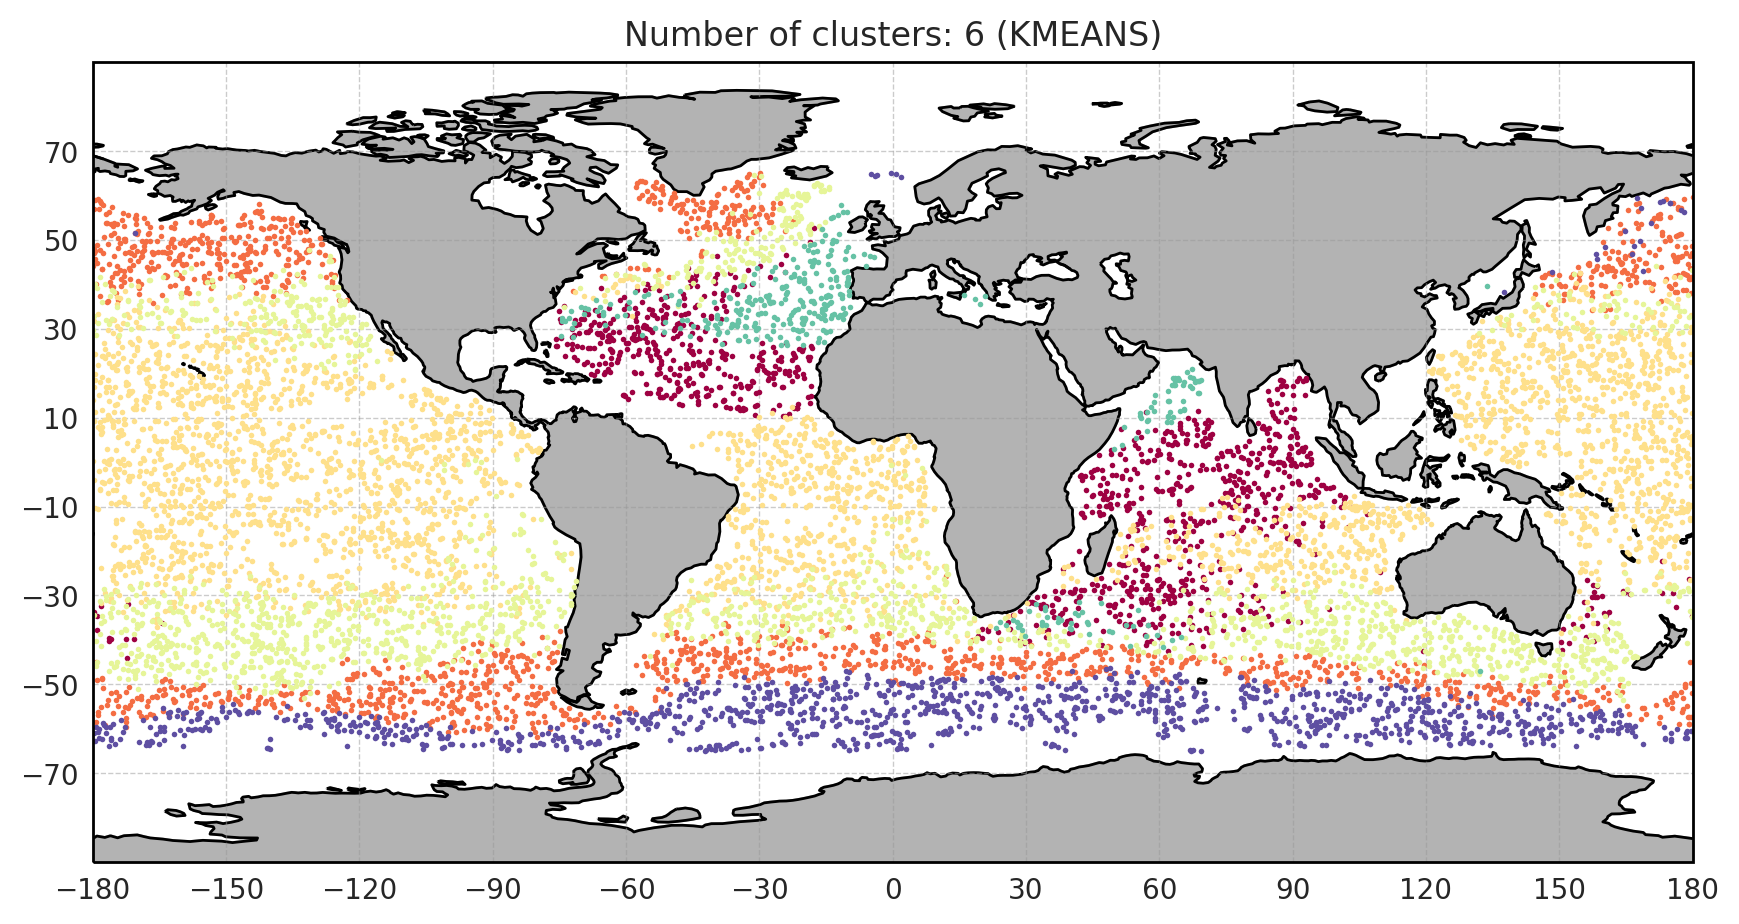

In [22]:
fig, proj, ax = create_map(extent=[-180, 180, -90, 90])

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 0.2]
    print("Cluster: ", k, col)
    
    class_member_mask = (RES.KMEANS == k)

    plt.plot(RES.LONGITUDE[class_member_mask],
                RES.LATITUDE[class_member_mask],
                 'o', markerfacecolor=tuple(col),
                 markeredgecolor='none', markersize=2,  
             label="Class %i"%(k), transform=proj)

plt.title('Number of clusters: %d (KMEANS)' % n_clusters_)
# plt.legend()
plt.show()

## Exercice

Implement and visualize results from another clusterring method available in scikit-learn